In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

from sklearn import datasets

In [2]:
iris = datasets.load_iris()
cols = iris.feature_names
data = iris.data

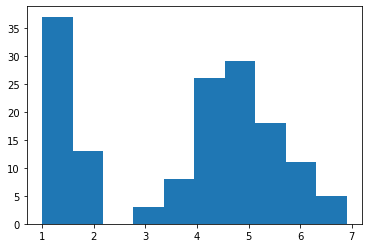

In [3]:
plt.hist(data[:,2])
plt.show()

In [4]:
from numpy import sqrt, pi, exp, log
class normal:
    def __init__(self, mu, sigma, x):
        self.mu = mu
        self.sigma = sigma
        self.x = x
    def pdf(self):
        e = (self.x - self.mu)**2/(2 * self.sigma**2)
        return scipy.stats.norm(self.mu, self.sigma).pdf(self.x)
        #return (self.sigma * sqrt(2*pi))**-1 * exp(-e)

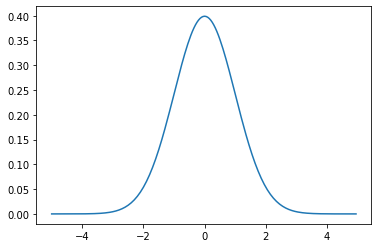

In [5]:
#data[:, 2]
dummy_data = np.arange(-5,5,0.05)
n1 = normal(mu=0, sigma=1, x=dummy_data)
plt.plot(dummy_data, n1.pdf());

In [6]:
class gmm():
    def __init__(self, k, data):
        self.m = data.shape[0]
        self.data = data.reshape(1, -1)
        self.k = k
        self.mu =  np.random.uniform(low=0, high=10, size=(k, 1))
        self.sigma = np.random.uniform(low=0, high=10, size=(k, 1))
        self.prob = np.empty((k, self.m), np.float64)
        self.post_prob = np.empty((k, self.m), np.float64)
        self.prior = np.repeat(1/k, k).reshape(k, 1)

    def probility(self, mu, sigma):
        prob = np.empty((0, self.m), np.float64)
        for i in range(self.k):
            p = scipy.stats.norm(mu[i], sigma[i]).pdf(self.data)
            prob = np.append(prob, p, axis=0)
        return prob

    def posterior_probability(self):
        post_prob = np.empty((0, self.m), np.float64)
        for i in range(self.k):
            idx = list(range(self.k))
            idx.remove(i)
            a = (self.prob[i, :] * self.prior[i])
            b = (self.prob[idx, :] * self.prior[idx]).sum(axis=0).reshape(1, -1)
            pp = a/(a + b)
            post_prob = np.append(post_prob, pp, axis=0)
        return post_prob

    def log_likelihood(self, prob):
        return log(prob).sum(axis=1).sum(axis=0)

    def new_value(self):
        wt_post_prob = self.post_prob / self.post_prob.sum(axis=1).reshape(-1, 1)
        
        # new mean assignment
        mu = wt_post_prob.dot(self.data.T)
        
        # new sd assignment
        sigma = np.empty((0, 1), np.float64)
        for i in range(self.k):
            s = sqrt((self.post_prob[i, :] * (self.data - self.mu[i])**2).sum(axis=1)).reshape(-1, 1)
            sigma = np.append(sigma, s, axis=0)
        return mu, sigma

    def assignment(self):
        mu, sigma = self.new_value()
        prob = self.probility(mu, sigma)
        ll = self.log_likelihood(prob)
        
        if ll <= self.log_likelihood_value[self.num_iter]:
            do_break = True
        else:
            do_break = False
            self.mu = mu
            self.sigma = sigma
        return do_break

    def fit(self, num_iter, verbose = True):
        
        self.log_likelihood_value = np.empty(0, np.float64)
        for i in range(num_iter):
            self.num_iter = i
            self.prob = self.probility(self.mu, self.sigma)
            self.log_likelihood_value = np.append(self.log_likelihood_value, self.log_likelihood(self.prob))
            
            self.post_prob = self.posterior_probability()
            self.prior = self.post_prob.sum(axis=1)/self.post_prob.sum(axis=1).sum(axis=0)

            if verbose:
                print("mean:", self.mu.T[0, :], "standard deviation:", self.sigma.T[0], "log likelihood:", self.log_likelihood_value[self.num_iter])
                
            if self.assignment():
                break
        

In [7]:
X = np.sort(data[:, 2])
model_list = []
for i in range(100):
    model_list.append(gmm(k=2, data=X))
    model_list[i].fit(10, verbose = False)

C:\Users\smrut\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
C:\Users\smrut\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\smrut\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\smrut\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\smrut\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1721: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\smrut\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1722: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


In [8]:
ll_array = np.array([model.log_likelihood_value[-1] for model in model_list])
model_list = np.array(model_list)[~np.isnan(ll_array)]

In [9]:
model_index = np.argmax([model.log_likelihood_value[-1] for model in model_list])
model = model_list[model_index]

In [10]:
print("log likelihood", model.log_likelihood_value[-1])
print("mean", model.mu)
print("standar dev", model.sigma)
print("weights", model.prior)

log likelihood -640.9881707161069
mean [[4.14977517]
 [4.32857501]]
standar dev [[2.24970482]
 [3.07211187]]
weights [0.54270261 0.45729739]


In [11]:
(model.post_prob / model.post_prob.sum(axis=1).reshape(-1, 1)).sum(axis=1)

array([1., 1.])

In [12]:
for i in range(model.k):
    if i == 0:
        wx = model.prior[i] * model.prob[i]
    else:
        wx += model.prior[i] * model.prob[i]

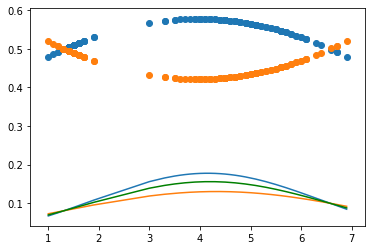

In [13]:
for i in range(model.k):
    plt.plot(X, model.prob[i])
    plt.scatter(X, model.post_prob[i])
    #plt.scatter(((model.post_prob.T>0.5) * X.reshape(-1,1))[:,i], np.zeros(X.shape[0]))
plt.plot(X, wx, c="green")

In [14]:
model.prior

array([0.54270261, 0.45729739])

In [15]:
model.prob.T

array([[0.06654647, 0.07220331],
       [0.07074958, 0.07475562],
       [0.0750697 , 0.07731619],
       [0.0750697 , 0.07731619],
       [0.07949639, 0.07987978],
       [0.07949639, 0.07987978],
       [0.07949639, 0.07987978],
       [0.07949639, 0.07987978],
       [0.07949639, 0.07987978],
       [0.07949639, 0.07987978],
       [0.07949639, 0.07987978],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08401794, 0.08244097],
       [0.08862138, 0.08499418],
       [0.08862138, 0.08499418],
       [0.08862138, 0.08499418],
       [0.08862138, 0.08499418],
       [0.08862138, 0.08499418],
       [0.08862138, 0.08499418],
       [0.

In [16]:
model.post_prob.T

array([[0.47961494, 0.52038506],
       [0.48623404, 0.51376596],
       [0.49262895, 0.50737105],
       [0.49262895, 0.50737105],
       [0.49879721, 0.50120279],
       [0.49879721, 0.50120279],
       [0.49879721, 0.50120279],
       [0.49879721, 0.50120279],
       [0.49879721, 0.50120279],
       [0.49879721, 0.50120279],
       [0.49879721, 0.50120279],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.50473679, 0.49526321],
       [0.51044607, 0.48955393],
       [0.51044607, 0.48955393],
       [0.51044607, 0.48955393],
       [0.51044607, 0.48955393],
       [0.51044607, 0.48955393],
       [0.51044607, 0.48955393],
       [0.